В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.read_csv("~/bank-customer-churn-prediction-dlu-course-c-2/train.csv")

In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


In [3]:
train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [4]:
train_df, val_df = train_test_split(train, test_size=0.25, stratify=train["Exited"], random_state=42)

2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [5]:
input_cols = list(train.columns)[1:-1]
target_col = 'Exited'

In [6]:
print(input_cols)

['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


In [7]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [8]:
import numpy as np

In [9]:
numeric_cols = train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train.select_dtypes('object').columns.tolist()

In [10]:
numeric_cols, categorical_cols

(['id',
  'CustomerId',
  'CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary',
  'Exited'],
 ['Surname', 'Geography', 'Gender'])

In [11]:
numeric_cols.remove('id')
numeric_cols.remove('Exited')

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [12]:
train[numeric_cols].describe().round(2)

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00,15000.00
mean,15691456.68,658.94,37.74,5.03,42729.79,1.59,0.79,0.49,117784.67
std,135205.03,72.26,8.22,2.78,59727.31,0.53,0.41,0.50,45734.45
min,1581102.00,431.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58
25%,15635143.00,603.00,32.00,3.00,0.00,1.00,1.00,0.00,83058.14
50%,15690175.00,662.00,37.00,5.00,0.00,2.00,1.00,0.00,123584.87
75%,15757181.50,708.00,42.00,7.00,109531.02,2.00,1.00,1.00,156884.70
max,15815690.00,850.00,74.00,10.00,209767.31,4.00,1.00,1.00,199992.48


In [13]:
train_inputs.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
8263,15679299.0,Toscani,696.0,France,Male,32.0,5.0,130627.66,1.0,1.0,1.0,86786.41
14199,15804862.0,Kuo,632.0,Germany,Female,32.0,4.0,119825.75,1.0,1.0,0.0,177737.04
1856,15613140.0,Ejimofor,679.0,France,Female,22.0,4.0,0.00,2.0,1.0,1.0,162599.54
3013,15651955.0,Onochie,705.0,France,Male,48.0,3.0,0.00,2.0,1.0,0.0,119814.25
8266,15768471.0,Chukwuemeka,696.0,France,Female,35.0,7.0,0.00,2.0,1.0,0.0,100423.88


Для початку виконаю підготовку числових даних. Вище можна побачити, що немає пропущених значень, тобто запонювати нічого не потрібно. Виконаю масштабування числових ознак за допомогою MinMaxScaler

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler()

In [16]:
scaler.fit(train_inputs[numeric_cols])

MinMaxScaler()

In [17]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])

In [18]:
train_inputs[numeric_cols].describe().round(2)

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,11250.00,11250.00,11250.00,11250.00,11250.00,11250.00,11250.00,11250.00,11250.00
mean,0.99,0.54,0.36,0.50,0.20,0.20,0.79,0.49,0.59
std,0.01,0.17,0.15,0.28,0.29,0.18,0.41,0.50,0.23
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.99,0.41,0.26,0.30,0.00,0.00,1.00,0.00,0.42
50%,0.99,0.55,0.35,0.50,0.00,0.33,1.00,0.00,0.62
75%,1.00,0.66,0.44,0.70,0.52,0.33,1.00,1.00,0.78
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


Категоріальні дані також не містять пропущених значень

In [19]:
train_inputs[categorical_cols].nunique()

Surname      720
Geography      3
Gender         2
dtype: int64

In [20]:
train_inputs[categorical_cols].describe()

,Surname,Geography,Gender
count,11250,11250,11250
unique,720,3,2
top,Ch'iu,France,Male
freq,193,6753,6449


тут створюю нову колонку в якій 'чоловік' відповідає значенню 0, а 'жінка' - значенню 1

In [21]:
gender_codes = {'Male': 0, 'Female': 1}
train['gender_code'] = train.Gender.map(gender_codes)

за домогою onehotencoder закодую колонку Geography

In [22]:
from sklearn.preprocessing import OneHotEncoder

In [23]:
categorical_col = ['Geography'] 

In [24]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [25]:
encoder.fit(train_inputs[categorical_col]) 

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [26]:
encoded_cols = list(encoder.get_feature_names_out(categorical_col))
print(encoded_cols)

['Geography_France', 'Geography_Germany', 'Geography_Spain']


In [27]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_col])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_col])

In [28]:
train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,gender_code
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0,0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0,1
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0,1
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0,0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0,1


- виконую кодування даних в колонці з гендером
- видаляю колонку Geography з навчальної та валідіційної вибірки
- видаляю колонку з прізвищами (тому що вони не будуть давати ніякої користі при створенні моделі, а ще мають дуже багато значень)
- видаляю колонку з незакодованими значеннями гендеру

In [29]:
train_inputs['gender_code'] = train_inputs.Gender.map(gender_codes)

In [30]:
val_inputs['gender_code'] = val_inputs.Gender.map(gender_codes)

In [31]:
train_inputs.drop('Surname', axis=1, inplace=True)
val_inputs.drop('Surname', axis=1, inplace=True)
train_inputs.drop('Geography', axis=1, inplace=True)
val_inputs.drop('Geography', axis=1, inplace=True)

In [32]:
train_inputs.drop('Gender', axis=1, inplace=True)
val_inputs.drop('Gender', axis=1, inplace=True)

In [33]:
pd.set_option('display.max_columns', None)

In [34]:
train_inputs.head()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,gender_code
8263,0.990418,0.632458,0.259259,0.5,0.622726,0.000000,1.0,1.0,0.433916,1.0,0.0,0.0,0
14199,0.999239,0.479714,0.259259,0.4,0.571232,0.000000,1.0,0.0,0.888712,0.0,1.0,0.0,1
1856,0.985771,0.591885,0.074074,0.4,0.000000,0.333333,1.0,1.0,0.813017,1.0,0.0,0.0,1
3013,0.988497,0.653938,0.555556,0.3,0.000000,0.333333,1.0,0.0,0.599071,1.0,0.0,0.0,0
8266,0.996683,0.632458,0.314815,0.7,0.000000,0.333333,1.0,0.0,0.502109,1.0,0.0,0.0,1


In [35]:
val_inputs.head(11)

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,gender_code
1855,0.995468,0.267303,0.203704,0.9,0.570579,0.000000,0.0,0.0,0.279047,1.0,0.0,0.0,0
1273,0.990856,0.398568,0.425926,0.3,0.590481,0.000000,1.0,0.0,0.884371,0.0,1.0,0.0,0
5414,0.992607,0.453461,0.240741,0.7,0.000000,0.000000,1.0,1.0,0.751226,1.0,0.0,0.0,0
10923,0.985575,0.396181,0.703704,0.3,0.000000,1.000000,1.0,0.0,0.514675,1.0,0.0,0.0,0
5835,0.997419,0.758950,0.444444,0.5,0.000000,0.000000,1.0,1.0,0.909003,0.0,0.0,1.0,1
5742,0.997944,0.365155,0.259259,0.2,0.559204,0.000000,1.0,1.0,0.658052,1.0,0.0,0.0,1
11019,0.992366,0.491647,0.537037,0.2,0.000000,0.333333,1.0,0.0,0.181214,0.0,0.0,1.0,0
12834,0.992251,0.551313,0.129630,0.6,0.000000,0.333333,0.0,1.0,0.490068,1.0,0.0,0.0,0
14082,0.997062,0.887828,0.222222,0.5,0.457302,0.000000,0.0,0.0,0.457814,1.0,0.0,0.0,0
7662,0.989058,0.429594,0.203704,0.5,0.000000,0.333333,1.0,0.0,0.916821,1.0,0.0,0.0,1


5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [36]:
pip install pyarrow --quiet


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [37]:
train_inputs.to_parquet('train_inputs.parquet')
val_inputs.to_parquet('val_inputs.parquet')

In [38]:
%%time
pd.DataFrame(train_targets).to_parquet('train_targets.parquet')
pd.DataFrame(val_targets).to_parquet('val_targets.parquet')

CPU times: user 10.2 ms, sys: 7.46 ms, total: 17.6 ms
Wall time: 17.1 ms


In [39]:
%%time

train_inputs = pd.read_parquet('train_inputs.parquet')
val_inputs = pd.read_parquet('val_inputs.parquet')

train_targets = pd.read_parquet('train_targets.parquet')[target_col]
val_targets = pd.read_parquet('val_targets.parquet')[target_col]

CPU times: user 58 ms, sys: 25 ms, total: 82.9 ms
Wall time: 424 ms


In [40]:
print('train_inputs:', train_inputs.shape)
print('train_targets:', train_targets.shape)
print('val_inputs:', val_inputs.shape)
print('val_targets:', val_targets.shape)

train_inputs: (11250, 13)
train_targets: (11250,)
val_inputs: (3750, 13)
val_targets: (3750,)


In [41]:
ls

 1_1_Основи_статистичного_аналізу_вибірок.ipynb
'1 Порядок_надання_дипломних_робот_на_перевірку.docx'
 1_Credit_EDA.ipynb
 42КБ_Шишкіна_ПР2.pdf
 Додаток_7_гарантійний_лист_згода_з_проектом_договору.pdf
'Додаток 7 п.4.6.pdf'
'Додаток 7 таблиця 1.pdf'
 Додаток_7_форма_1_відомості_учасника.pdf
 Логістична_регресія_з_ScikitLearn_Повна_ML_задача.ipynb
 сертиф.2.rar
 Шишкіна_КБ42_ЛР3.docx
 cars.csv
 credit/
 credit-20241215T123923Z-001.zip
'google-chrome-stable_current_amd64 (1).deb'
 HW_1_1_Основи_статистики.html
 HW_1_1_Основи_статистики.ipynb
 HW_1_2_Credit_EDA.ipynb
 HW_2_1_Лінійна_регресія_від_багатьох_змінних.ipynb
'HW_2_1_Матриці_і_вектори_(вступ_до_лін_алгебри).ipynb'
 HW_2_1_Побудова_лінійної_регресії_за_одною_ознакою.ipynb
 HW_2_1_Тестування_стат_гіпотез.ipynb
 HW_2_1_Функції_і_похідні.ipynb
 HW_2_2_Логістична_регресія_з_scikit_learn.ipynb
 HW_2_2_Математичне_формулювання_логістичної_регресії.ipynb
 HW_2_2_Поліноміальні_ознаки_Pipelines.ipynb
 Lecture_0_jupyter_demo.ipynb
 medical-

6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

непотрібні колонки були видалені у попредніх завданнях

In [42]:
from sklearn.linear_model import LogisticRegression

In [43]:
model = LogisticRegression(solver='liblinear')

In [44]:
model.fit(train_inputs, train_targets)

LogisticRegression(solver='liblinear')

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [45]:
train_preds = model.predict(train_inputs)

In [46]:
train_preds

array([0., 0., 0., ..., 0., 0., 0.])

In [47]:
train_targets

8263     0.0
14199    1.0
1856     0.0
3013     0.0
8266     0.0
        ... 
9493     0.0
7687     1.0
8143     0.0
11512    0.0
1292     1.0
Name: Exited, Length: 11250, dtype: float64

In [48]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [49]:
accuracy_score(train_targets, train_preds)

0.8747555555555555

In [50]:
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)

    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))

    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));

    return preds

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

Accuracy: 87.48%


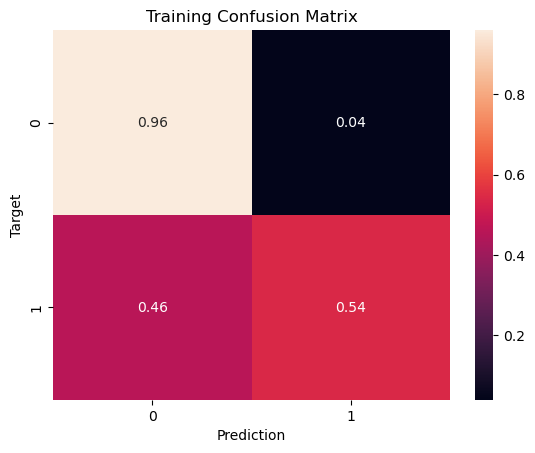

In [52]:
train_preds = predict_and_plot(train_inputs, train_targets, 'Training')

Accuracy: 87.09%


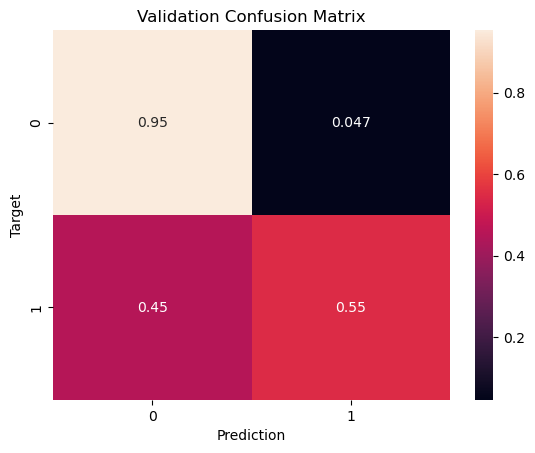

In [53]:
val_preds = predict_and_plot(val_inputs, val_targets, 'Validation')

In [54]:
confusion_matrix(train_targets, train_preds)

array([[8602,  359],
       [1050, 1239]])

In [55]:
from sklearn.metrics import f1_score

In [56]:
def get_f1_score(inputs, targets, name=''):
  preds = model.predict(inputs)

  f1_score_ = f1_score(targets, preds, pos_label=1.0)
  print(f"F1 score {name}: {f1_score_:.2f}%")

get_f1_score(train_inputs, train_targets, 'Training')
get_f1_score(val_inputs, val_targets, 'Validation')

F1 score Training: 0.64%
F1 score Validation: 0.63%


In [57]:
from sklearn.metrics import roc_curve, auc

def compute_auroc_and_build_roc(inputs, targets, name=''):
  # Predict probabilities
  y_pred_proba = model.predict_proba(inputs)[:, 1]

  # Compute ROC curve
  fpr, tpr, thresholds = roc_curve(targets, y_pred_proba, pos_label=1.0)

    # Compute AUROC
  roc_auc = auc(fpr, tpr)
  print(f'AUROC for {name}: {roc_auc:.2f}')

  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
  plt.legend(loc="lower right")
  plt.show()

AUROC for Training: 0.88


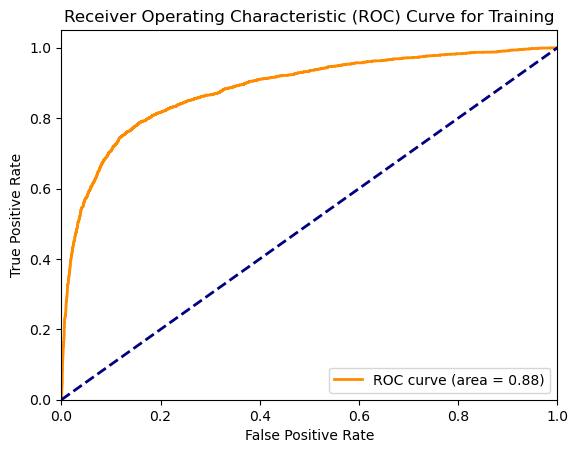

AUROC for Validation: 0.88


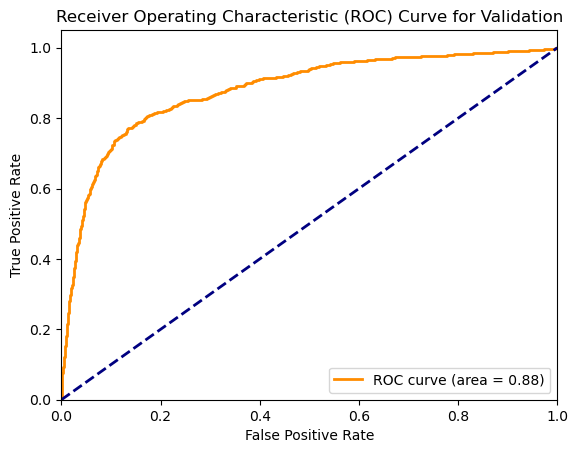

In [58]:
compute_auroc_and_build_roc(train_inputs, train_targets, 'Training')
compute_auroc_and_build_roc(val_inputs, val_targets, 'Validation')

якість моделі не дуже хороша

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [59]:
train['Exited'].value_counts()

0.0    11948
1.0     3052
Name: Exited, dtype: int64

In [60]:
def all_no(inputs):
    return np.full(len(inputs), 0.0)

In [61]:
accuracy_score(train_targets, all_no(train_inputs))

0.7965333333333333

модель передбачає краще, ніж модель, що передбачає усі нулі

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [62]:
import joblib

In [63]:
bank_pred = {
    'model': model,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

In [64]:
joblib.dump(bank_pred, 'bank_pred.joblib')

['bank_pred.joblib']

In [65]:
model_2 = joblib.load('bank_pred.joblib')

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [96]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import joblib

def predict_raw_df(model_file, input_df: pd.DataFrame):
    model = model_2['model']
    scaler = model_2['scaler']
    encoder = model_2['encoder']
    numeric_cols = model_2['numeric_cols']
    categorical_cols = model_2['categorical_cols']
    
    input_df = input_df.copy()
    
    drop_cols = ['Surname']
    input_df = input_df.drop(columns=[col for col in drop_cols if col in input_df.columns], errors='ignore')
    
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    
    gender_codes = {'Male': 0, 'Female': 1}
    if 'Gender' in categorical_cols:
        input_df['gender_code'] = input_df['Gender'].map(gender_codes)
        input_df = input_df.drop(columns=['Gender'])
    
    if 'Geography' in categorical_cols:
        geo_encoded = encoder.transform(input_df[['Geography']])
        geo_encoded_df = pd.DataFrame(geo_encoded, columns=encoder.get_feature_names_out(['Geography']))
        input_df = input_df.drop(columns=['Geography']).reset_index(drop=True)
        input_df = pd.concat([input_df, geo_encoded_df], axis=1)
    
    feature_cols = numeric_cols + [col for col in input_df.columns if col.startswith('Geography_')] + ['gender_code']
    X_input = input_df[feature_cols]
    
    prob = model.predict_proba(X_input)[:,1]
    return prob


In [82]:
numeric_cols

['CustomerId',
 'CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [97]:
predict_raw_df(model_2, train)

array([0.00639276, 0.0371277 , 0.36892598, ..., 0.90078979, 0.20034659,
       0.10024846])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [88]:
test_raw_df = pd.read_csv("~/bank-customer-churn-prediction-dlu-course-c-2/test.csv")

In [98]:
test_raw_df["Exited"] = predict_raw_df("bank_pred.joblib", test_raw_df)

In [91]:
test_raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86,0.075696
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28,0.034987
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45,0.151133
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87,0.195176
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97,0.055571


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [92]:
sample_submission_df = pd.read_csv("~/bank-customer-churn-prediction-dlu-course-c-2/sample_submission.csv")

In [99]:
sample_submission_df["Exited"] = predict_raw_df("bank_pred.joblib", test_raw_df)

In [100]:
sample_submission_df.head()

,id,Exited
0,15000,0.075696
1,15001,0.034987
2,15002,0.151133
3,15003,0.195176
4,15004,0.055571


In [104]:
sample_submission_df.to_csv("submission_log_reg.csv", index=False, float_format="%.1f")

In [105]:
submission_log_reg = pd.read_csv("~/Завантаження/submission_log_reg.csv")

In [106]:
submission_log_reg.head()

,id,Exited
0,15000,0.1
1,15001,0.0
2,15002,0.2
3,15003,0.2
4,15004,0.1
